<a href="https://colab.research.google.com/github/fatema373/NLP/blob/main/weather_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM,Dense,SimpleRNN,GRU,BatchNormalization
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping

# 1- Dataset


In [ ]:
!wget 'https://zenodo.org/record/4770937/files/weather_prediction_dataset.csv'

--2023-05-12 06:49:37--  https://zenodo.org/record/4770937/files/weather_prediction_dataset.csv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2773815 (2.6M) [text/plain]
Saving to: ‘weather_prediction_dataset.csv’

weather_prediction_ 100%[===================>]   2.64M   302KB/s    in 9.0s    

2023-05-12 06:49:49 (302 KB/s) - ‘weather_prediction_dataset.csv’ saved [2773815/2773815]



## Read Dataset


In [ ]:
df= pd.read_csv('/content/weather_prediction_dataset.csv')
df

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,20091229,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,20091230,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,20091231,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9


In [ ]:
def split_date(date_):
  year=date_[:4]
  month=date_[4:6]
  day=date_[6:]
  return f"{year}-{month}-{day}"

In [ ]:
# to get year col for splitting data based on year in the later steps we convert date to be like yyyy-mm-dd
df['DATE']=df['DATE'].apply(lambda x:split_date(str(x)))

In [ ]:
df

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,2000-01-01,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,2000-01-02,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,2000-01-03,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,2000-01-04,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,2000-01-05,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2009-12-28,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,2009-12-29,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,2009-12-30,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,2009-12-31,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9


In [ ]:
df['DATE']=pd.to_datetime(df['DATE'])
df['Year'] = df['DATE'].dt.year

## Apply PCA for Feature Reduction



In [ ]:
#get all features and drop unnecessery cols
X=df.drop(['TOURS_temp_max','Year','DATE'],axis=1)
X

,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,...,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min
0,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,...,-2.3,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2
1,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,...,1.3,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6
2,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,...,0.8,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6
3,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,...,3.5,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4
4,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,...,-0.6,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8,...,1.1,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8
3650,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0,...,-8.0,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2
3651,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,11.5,...,-9.5,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7
3652,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,7.9,...,-7.6,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2


Text(0, 0.5, 'Variance')

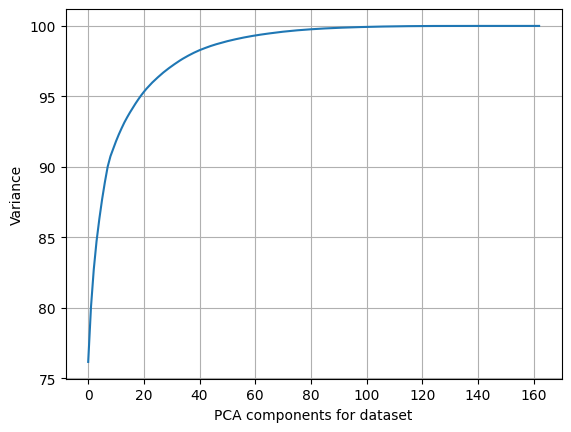

In [ ]:
#get the best number of pca componenects that hold much variation of the data
pca_ = PCA()
pca_.fit(X)
plt.grid(True)
plt.plot(np.cumsum(pca_.explained_variance_ratio_ * 100))
plt.xlabel('PCA components for dataset')
plt.ylabel('Variance')

In [ ]:
# apply PCA with 50 component that holds more that 96% variation of the data
pca_X = PCA(n_components=50)
X_pca=pca_X.fit_transform(X=X)
X_pca

array([[ 66.77342123,  -1.79175967,   3.45770444, ...,  -2.39577643,
          1.38515651,  -1.60624211],
       [ 57.03037348,  -0.48242753,   1.45524422, ...,   1.3771734 ,
         -0.23094115,   0.92669801],
       [ 51.36066075,  -7.78526547,   1.58695298, ...,   3.02240958,
          0.26796975,   0.33237087],
       ...,
       [ 55.70747237, -13.18496211,  17.19857006, ...,  -0.44130254,
         -3.65366451,  -0.25406302],
       [ 62.98702838, -11.54132386,   9.84880933, ...,  -1.12848279,
         -0.43459488,  -0.81750154],
       [ 74.14393429,  -6.71064713,   2.15620652, ...,  -2.125751  ,
         -1.42232915,  -1.36351233]])

## Dataset splitting

In [ ]:
#convert the pca features to dataframe and add (Year, TOURS_temp_max) cols to it,
# so we have our new data in X_df variable
X_df=pd.DataFrame(X_pca)
X_df['Year']=df['Year']
X_df['TOURS_temp_max']=df['TOURS_temp_max']



```
X_df is our new dataset that (PCA output)
```



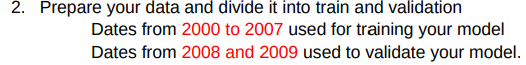

In [ ]:
df_train=X_df.loc[(X_df['Year']<=2007)]
df_train

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Year,TOURS_temp_max
0,66.773421,-1.791760,3.457704,-4.769862,-10.042634,-12.891867,6.289041,9.864113,-7.816788,-6.586971,...,0.083403,-1.947575,1.051896,2.267699,0.020822,-2.395776,1.385157,-1.606242,2000,9.8
1,57.030373,-0.482428,1.455244,-10.030863,-9.124562,-9.465604,3.599904,6.890710,-3.871920,-1.223798,...,-3.056890,-0.698035,-1.393419,1.635033,0.085661,1.377173,-0.230941,0.926698,2000,9.2
2,51.360661,-7.785265,1.586953,-14.539712,-8.898830,-3.918864,-0.481013,-1.419834,3.128625,0.244656,...,-0.803440,1.042818,0.797823,-0.698182,-0.970886,3.022410,0.267970,0.332371,2000,9.6
3,47.290651,-4.169076,7.389767,-20.005109,-5.278304,-2.563873,-1.583863,3.388227,10.369761,5.296306,...,-0.154748,-2.382816,0.395826,1.645789,-1.598719,-0.640167,-2.960994,0.561336,2000,10.8
4,51.470725,4.958848,8.822066,-5.844868,-1.637902,-5.114916,-1.331651,-5.337218,-0.194580,-2.472049,...,-2.110405,-0.031615,-1.584737,1.080592,-2.017555,-2.798466,0.385677,-1.271342,2000,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,60.815354,-0.657352,-9.922620,-14.761007,-11.875622,-4.223855,-6.927953,-1.021256,4.782368,-0.897857,...,-1.033142,0.082017,1.140650,-0.005697,0.382731,0.473141,1.217133,-0.742795,2007,8.8
2918,59.293031,1.315722,-5.732258,-23.225187,-11.800919,-4.074687,-5.467431,-7.103574,6.256218,1.020699,...,0.046886,-0.059609,2.328722,1.252626,1.722481,1.495898,-0.392550,2.021359,2007,6.8
2919,59.880382,2.151522,0.772387,-27.019763,-9.400085,1.662727,-10.269578,-8.794580,9.598084,6.897346,...,-0.319607,-0.959159,-0.435300,-1.437425,0.523406,0.279897,0.956634,-0.908883,2007,9.3
2920,58.750465,-5.093588,-5.726017,-16.835349,-7.137829,-8.088948,0.475180,-0.678328,1.449032,0.358662,...,-0.534946,-2.258101,1.461003,-0.624846,-1.433732,-0.671165,-1.189863,0.912979,2007,4.5


In [ ]:
df_valid=X_df.loc[(X_df['Year']>2007)& (X_df['Year']<=2009)]
df_valid

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Year,TOURS_temp_max
2922,78.373027,4.833665,-9.238407,-8.590132,-7.549212,-1.758182,2.442494,3.706452,-6.727686,-0.331447,...,-0.051548,-1.724446,-0.699047,0.531358,-1.355075,0.285012,-0.621024,1.104563,2008,4.5
2923,81.428546,7.163417,-6.222454,-7.311926,4.657115,2.121954,-7.788295,-4.835467,-3.278700,-0.878287,...,1.362892,-1.037630,-1.077583,-1.100430,-0.915501,-0.782416,2.341298,-0.526508,2008,3.8
2924,78.122433,-5.081272,-2.787617,-1.626022,1.388118,-2.620080,-5.984365,0.225241,2.319924,0.361619,...,1.248197,0.836153,0.945556,0.195886,0.348954,0.048574,-0.367974,-0.483115,2008,7.1
2925,70.610846,-5.351110,2.011145,-4.279966,-4.671060,-10.560224,-4.989417,-2.948891,7.570662,-2.528067,...,-2.228610,0.261863,1.181871,-0.816310,-2.330420,-0.335779,-0.143666,-3.103568,2008,10.0
2926,58.823458,-10.864099,8.105806,-4.323201,-4.286795,-17.909828,-4.850852,-2.878568,6.013180,0.210372,...,2.777622,-0.288983,0.965191,0.138145,2.015198,0.767883,2.452980,1.001576,2008,10.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,68.215466,-8.585055,6.564309,2.670935,-1.888612,-3.580520,-1.063522,-1.221912,-2.465142,0.904422,...,1.140252,-0.605222,-0.177157,-0.690738,1.095438,-1.669189,0.490874,-2.127325,2009,9.7
3649,67.194341,-2.123492,4.822774,2.595998,-0.589877,4.269149,3.884345,-1.783321,-2.166496,2.821568,...,0.621417,-0.985052,0.344947,-1.841954,-0.149527,1.333088,1.243222,-1.948109,2009,10.6
3650,65.372106,-3.291849,9.438260,19.151028,-6.485364,-2.982349,5.286826,-2.216517,7.275442,-0.583132,...,0.436102,1.579373,1.912176,1.079897,1.308012,-1.559352,-0.911685,0.226712,2009,14.5
3651,55.707472,-13.184962,17.198570,27.782159,-11.142894,-11.818855,10.322150,-1.980075,5.231712,4.508835,...,-0.009558,-2.391623,1.286348,1.505698,0.063780,-0.441303,-3.653665,-0.254063,2009,11.3


In [ ]:
df_test=X_df.loc[(X_df['Year']>2009)]
df_test

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,Year,TOURS_temp_max
3653,74.143934,-6.710647,2.156207,28.310164,2.41242,3.300929,-3.18938,-0.746041,2.527182,0.289093,...,-0.160662,-1.639116,-2.384585,0.967231,1.534027,-2.125751,-1.422329,-1.363512,2010,1.8


In [ ]:
X_train=np.array(df_train.drop(['TOURS_temp_max','Year'],axis=1))
X_valid=np.array(df_valid.drop(['TOURS_temp_max','Year'],axis=1))
X_test=np.array(df_test.drop(['TOURS_temp_max','Year'],axis=1))

In [ ]:
y_train=np.array(df_train['TOURS_temp_max'])
y_valid=np.array(df_valid['TOURS_temp_max'])
y_test=np.array(df_test['TOURS_temp_max'])

# Modeling Part

In [ ]:
X_train.shape

(2922, 50)

In [ ]:
class Modeling:
  def __init__(self,X_train,y_train,X_valid,y_valid, time_step):
    self.time_step=time_step
    self.X_train,self.y_train=self.create_batch(X_train,y_train,time_step)
    self.X_valid,self.y_valid=self.create_batch(X_valid,y_valid,time_step)

    self.LSTM_model=self.LSTM_(input_shape=(self.time_step,self.X_train.shape[2]),time_step=self.time_step)
    self.RNN_model=self.RNN(input_shape=(time_step,self.X_train.shape[2]),time_step=self.time_step)
    self.GRU_model=self.GRU(input_shape=(time_step,self.X_train.shape[2]),time_step=self.time_step)
  #this function create the seq we want our data to be with the shape of it to pass it to LSTM model
  def create_batch(self,X_,y_, n_steps):
    X, y = [],[]
    for i in range(len(X_)-n_steps-1):
      X.append(X_[i:i+n_steps])
      y.append(y_[i:i+n_steps])
    X=np.array(X)
    X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
    return X, np.array(y)

  # Define the LSTM model
  def LSTM_(self,input_shape,time_step):
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(self.time_step,activation="relu", input_shape=input_shape,return_sequences=True,dropout=0.3))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr=0.01)
    LSTM_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    LSTM_model.summary()
    return LSTM_model
  # Define the RNN model
  def RNN(self,input_shape,time_step):
    RNN_model = Sequential()
    RNN_model.add(SimpleRNN(units=time_step,activation="relu", return_sequences=True, input_shape=input_shape))
    RNN_model.add(BatchNormalization())
    RNN_model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr=0.01)
    RNN_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    RNN_model.summary()
    return RNN_model
  # Define the GRU model
  def GRU(self,input_shape,time_step):
    GRU_model = Sequential()
    GRU_model.add(GRU(time_step,activation="relu", return_sequences=True, input_shape=input_shape))
    GRU_model.add(BatchNormalization())
    GRU_model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr=0.01)
    GRU_model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    GRU_model.summary()
    return GRU_model
  def fit_models(self):
    #Applying early stop based on val loss
    early_stop_LSTM = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    early_stop_RNN = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    early_stop_GRU = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    print("Training LSTM Model:")
    self.LSTM_model.fit(self.X_train,self.y_train,epochs=100,validation_data=(self.X_valid, self.y_valid),verbose=1,callbacks=early_stop_LSTM)
    print("LSTM model early stopping in epoch no: {}".format(early_stop_LSTM.stopped_epoch+1))

    print("Training RNN Model:")
    self.RNN_model.fit(self.X_train,self.y_train,epochs=100,validation_data=(self.X_valid, self.y_valid),verbose=1,callbacks=early_stop_RNN)
    print("RNN model early stopping in epoch no: {}".format(early_stop_RNN.stopped_epoch+1))
    print("Training GRU Model:")
    self.GRU_model.fit(self.X_train,self.y_train,epochs=100,validation_data=(self.X_valid, self.y_valid),verbose=1,callbacks=early_stop_GRU)
    print("GRU model early stopping in epoch no: {}".format(early_stop_GRU.stopped_epoch+1))



# Time step setting

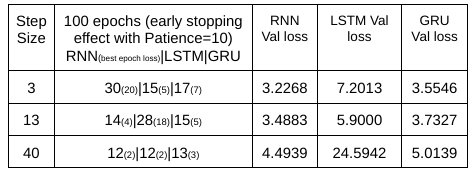

In [ ]:
modeling_3=Modeling(X_train,y_train,X_valid,y_valid,3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3, 3)              648       
                                                                 
 batch_normalization_3 (Batc  (None, 3, 3)             12        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 3, 1)              4         
                                                                 
Total params: 664
Trainable params: 658
Non-trainable params: 6
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3, 3)              162       
                                                                 
 batch_normalization_4 (Batc  (None, 3, 3)             12        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 3, 1)              4         
                                                                 
Total params: 178
Trainable params: 172
Non-trainable params: 6
_________________________________________________________________


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 3, 3)              495       
                                                                 
 batch_normalization_5 (Batc  (None, 3, 3)             12        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 3, 1)              4         
                                                                 
Total params: 511
Trainable params: 505
Non-trainable params: 6
_________________________________________________________________


In [ ]:
modeling_3.fit_models()

Training LSTM Model:
Epoch 1/100
92/92 [==============================] - 6s 14ms/step - loss: 229.9628 - mse: 229.9628 - val_loss: 121.9342 - val_mse: 121.9342
Epoch 2/100
92/92 [==============================] - 1s 10ms/step - loss: 52.3997 - mse: 52.3997 - val_loss: 7.2363 - val_mse: 7.2363
Epoch 3/100
92/92 [==============================] - 1s 10ms/step - loss: 15.5250 - mse: 15.5250 - val_loss: 7.6113 - val_mse: 7.6113
Epoch 4/100
92/92 [==============================] - 1s 10ms/step - loss: 15.0205 - mse: 15.0205 - val_loss: 8.1658 - val_mse: 8.1658
Epoch 5/100
92/92 [==============================] - 2s 20ms/step - loss: 14.6399 - mse: 14.6399 - val_loss: 7.2013 - val_mse: 7.2013
Epoch 6/100
92/92 [==============================] - 1s 13ms/step - loss: 14.6840 - mse: 14.6840 - val_loss: 7.7978 - val_mse: 7.7978
Epoch 7/100
92/92 [==============================] - 1s 9ms/step - loss: 14.8708 - mse: 14.8708 - val_loss: 7.4315 - val_mse: 7.4315
Epoch 8/100
92/92 [=================

In [ ]:
modeling_13=Modeling(X_train,y_train,X_valid,y_valid,13)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 13, 13)            3328      
                                                                 
 batch_normalization_6 (Batc  (None, 13, 13)           52        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 13, 1)             14        
                                                                 
Total params: 3,394
Trainable params: 3,368
Non-trainable params: 26
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 13, 13)            832       
                             

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 13, 13)            2535      
                                                                 
 batch_normalization_8 (Batc  (None, 13, 13)           52        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 13, 1)             14        
                                                                 
Total params: 2,601
Trainable params: 2,575
Non-trainable params: 26
_________________________________________________________________


In [ ]:
modeling_13.fit_models()

Training LSTM Model:
Epoch 1/100
91/91 [==============================] - 4s 27ms/step - loss: 155.9917 - mse: 155.9917 - val_loss: 7.6351 - val_mse: 7.6351
Epoch 2/100
91/91 [==============================] - 4s 47ms/step - loss: 9.7739 - mse: 9.7739 - val_loss: 7.7476 - val_mse: 7.7476
Epoch 3/100
91/91 [==============================] - 2s 26ms/step - loss: 9.1878 - mse: 9.1878 - val_loss: 8.2243 - val_mse: 8.2243
Epoch 4/100
91/91 [==============================] - 2s 25ms/step - loss: 8.2179 - mse: 8.2179 - val_loss: 8.5573 - val_mse: 8.5573
Epoch 5/100
91/91 [==============================] - 2s 25ms/step - loss: 8.4125 - mse: 8.4125 - val_loss: 8.4672 - val_mse: 8.4672
Epoch 6/100
91/91 [==============================] - 2s 26ms/step - loss: 7.9344 - mse: 7.9344 - val_loss: 8.1944 - val_mse: 8.1944
Epoch 7/100
91/91 [==============================] - 4s 40ms/step - loss: 8.1071 - mse: 8.1071 - val_loss: 9.3056 - val_mse: 9.3056
Epoch 8/100
91/91 [==============================] 

In [ ]:
modeling_40=Modeling(X_train,y_train,X_valid,y_valid,40)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 40, 40)            14560     
                                                                 
 batch_normalization_9 (Batc  (None, 40, 40)           160       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 40, 1)             41        
                                                                 
Total params: 14,761
Trainable params: 14,681
Non-trainable params: 80
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 40, 40)            3640      
                          

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 40, 40)            11040     
                                                                 
 batch_normalization_11 (Bat  (None, 40, 40)           160       
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 40, 1)             41        
                                                                 
Total params: 11,241
Trainable params: 11,161
Non-trainable params: 80
_________________________________________________________________


In [ ]:
modeling_40.fit_models()

Training LSTM Model:
Epoch 1/100
89/89 [==============================] - 9s 77ms/step - loss: 129.6749 - mse: 129.6749 - val_loss: 55.9848 - val_mse: 55.9848
Epoch 2/100
89/89 [==============================] - 7s 81ms/step - loss: 32.0204 - mse: 32.0204 - val_loss: 24.5942 - val_mse: 24.5942
Epoch 3/100
89/89 [==============================] - 6s 67ms/step - loss: 35.8134 - mse: 35.8134 - val_loss: 78.2389 - val_mse: 78.2389
Epoch 4/100
89/89 [==============================] - 7s 84ms/step - loss: 30.2003 - mse: 30.2003 - val_loss: 54.1885 - val_mse: 54.1885
Epoch 5/100
89/89 [==============================] - 6s 67ms/step - loss: 26.1517 - mse: 26.1517 - val_loss: 54.7775 - val_mse: 54.7775
Epoch 6/100
89/89 [==============================] - 7s 82ms/step - loss: 24.8768 - mse: 24.8768 - val_loss: 59.7167 - val_mse: 59.7167
Epoch 7/100
89/89 [==============================] - 6s 67ms/step - loss: 24.5891 - mse: 24.5891 - val_loss: 58.6236 - val_mse: 58.6236
Epoch 8/100
89/89 [======

# `Conclusion`

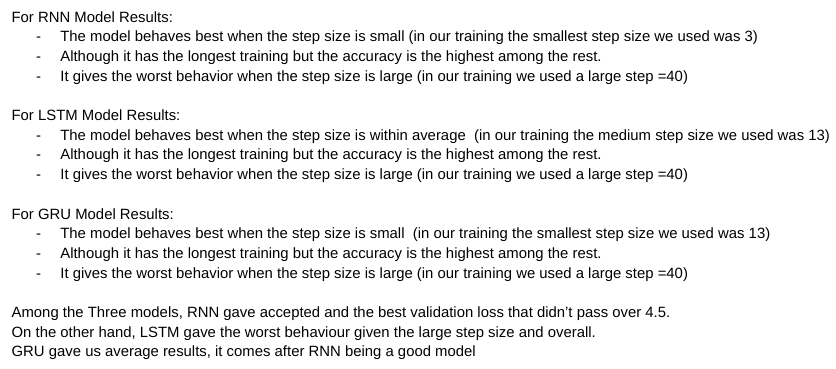